In [19]:
import os
import torch
import torchvision
import tarfile
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [20]:
project_name = '5-cifar10-resnet'

In [21]:
# Dowload the dataset
dataset_url = "https://s3.amazonaws.com/fast-ai-imageclas/cifar10.tgz"
download_url(dataset_url, '.')

# Extract from archive
with tarfile.open('./cifar10.tgz', 'r:gz') as tar:
    tar.extractall(path='./data',filter="data")
data_dir = './data/cifar10'

Using downloaded and verified file: ./cifar10.tgz


### Some changes for better model
1. Use test data for validation
2. Channel-wise data normalization: We will normalize the image tensors by subtracting the mean and dividing by the standard deviation across each channel. As a result, the mean of the data across each channel is 0, and standard deviation is 1.
3. Data Augmentation: It is a technique of artificially increasing the training set by creating modified copies of a dataset using existing data. Basically we can apply some transformation on images

In [22]:
# Data transforms (normalization & data augmentation)
stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)) # mean and standard deviation for each channel
train_tfms = tt.Compose([tt.RandomCrop(32, padding=4, padding_mode='reflect'), 
                         tt.RandomHorizontalFlip(),
                         tt.ToTensor(), 
                         tt.Normalize(*stats,inplace=True)])
valid_tfms = tt.Compose([tt.ToTensor(), tt.Normalize(*stats)]) 

In [23]:
train_ds = ImageFolder(data_dir+'/train',train_tfms)
valid_ds = ImageFolder(data_dir+'/test',valid_tfms) # validation dataset

batch_size = 128

In [24]:
train_dl = DataLoader(train_ds,batch_size,shuffle=True,num_workers=3)
valid_dl = DataLoader(valid_ds, batch_size*2, num_workers=3)

In [25]:
def denormalize(images, means, stds):
    means = torch.tensor(means).reshape(1, 3, 1, 1)
    stds = torch.tensor(stds).reshape(1, 3, 1, 1)
    return images * stds + means

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(9, 9))
        ax.set_xticks([]); ax.set_yticks([])
        denorm_images = denormalize(images, *stats)
        # .clamp(0, 1): Ensures pixel values are clipped to the valid range [0, 1] for visualization
        ax.imshow(make_grid(denorm_images[:64], nrow=8).permute(1, 2, 0).clamp(0,1)) 
        plt.show()
        break

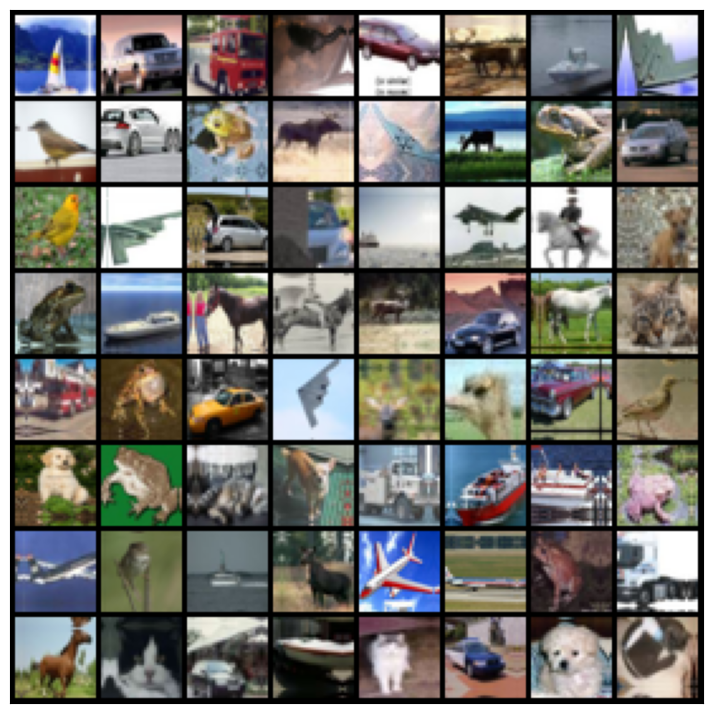

In [26]:
show_batch(train_dl)

## Model with Residual Blocks and Batch Normalization

A residual neural network (ResNet) is a deep learning architecture that uses residual functions to learn from layer inputs

![](https://miro.medium.com/max/1140/1*D0F3UitQ2l5Q0Ak-tjEdJg.png)

In [27]:
class SimpleResidualBlock(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        
    def forward(self, x):
        out = self.conv1(x)
        out = self.relu1(out)
        out = self.conv2(out)
        return self.relu2(out) + x # ReLU can be applied before or after adding the input

Also to improve the performance, after each convolutional layer, we'll add a batch normalization layer, which normalizes the outputs of the previous layer.

In [28]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  
        loss = F.cross_entropy(out, labels) 
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    
        loss = F.cross_entropy(out, labels)   
        acc = accuracy(out, labels)           
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

In [29]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
              nn.BatchNorm2d(out_channels), # batch normalization on the output
              nn.ReLU(inplace=True)]
    if pool:
        layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers) # * means pass all elements of list

class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        self.conv1 = conv_block(in_channels, 64)
        self.conv2 = conv_block(64, 128, pool=True)
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))
        
        self.conv3 = conv_block(128, 256, pool=True)
        self.conv4 = conv_block(256, 512, pool=True)
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))
        
        self.classifier = nn.Sequential(nn.MaxPool2d(4), # reduces dimension by 4
                                        nn.Flatten(), # flattens to tensor
                                        nn.Dropout(0.2), # randomly sets 20% of the input units to zero, which helps prevent overfitting
                                        nn.Linear(512, num_classes)) # input 512 means 512 input features

    def forward(self,xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

### Some changes for better training
1. Learning rate scheduling: changing learning rate after every batch of training. Here using "1cycle policy"
2. Weight decay: we multiply the sum of squares with another smaller number. This number is called weight decay or wd. Then we add this term to the loss function.<br/>
   **Loss = original loss function + wd * sum(w^2)**<br/>
   Now derivative of loss function will also count derivative wrt w
3. Exploding gradients refer to the problem that the gradients get too large in training, making the model unstable. Similarly, vanishing gradients refer to gradients getting too small in training.<br/>
   If the gradient gets too large, we rescale it to keep it small. More precisely, if ‖g‖ ≥ c, then<br/>
   **g <- c · g/‖g‖**<br/>
   where c is a hyperparameter, g is the gradient, and ‖g‖ is the norm of g. Since g/‖g‖ is a unit vector, after rescaling the new g will have norm c.

In [30]:
@torch.no_grad()
def evaluate(model,val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    history = []

    fc_params = model.classifier.parameters()
    # rest all parameters apart from fully connected layer
    cnn_params = [param for param in model.parameters() if param not in set(fc_params)]
    
    # Set up cutom optimizer with weight decay
    optimizer = opt_func([
                {'params': fc_params, 'lr': max_lr}, # higher rate for FC layer
                {'params': cnn_params, 'lr': max_lr/10}
            ], weight_decay=weight_decay)
    
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader)) # steps per epoch means total number of batches
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: # if set to true
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step() # do one epoch
            optimizer.zero_grad() # reset gradients so they don't accumulate
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step() # learning rate scheduling by 1cycle policy
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

### Adam optimizer
Basically, it is a combination of two gradient descent methods: Momentum and Root Mean Square Propogation (RMSProp)

In [31]:
epochs = 6
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam
model = ResNet9(3,10)

In [32]:
# %%time
# history = fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl, 
#                              grad_clip=grad_clip, 
#                              weight_decay=weight_decay, 
#                              opt_func=opt_func)

In [33]:
import torch
import torchvision
from torch.profiler import profile, record_function, ProfilerActivity

### Model profiling
FC - fully connected layer means every input neuron is connected to some output neuron<br/>
To specify per-layer learning rates, use per-parameter options. Pass as `dict` in optimizer function

In [ ]:
# Using profiler to analyze execution time
with profile(activities=[ProfilerActivity.CPU], record_shapes=True) as prof:
    with record_function("model_inference"):
        fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)

Epoch [0], last_lr: 0.00602, train_loss: 1.4751, val_loss: 1.1542, val_acc: 0.6013
Epoch [1], last_lr: 0.00994, train_loss: 1.0361, val_loss: 0.8783, val_acc: 0.7061
Epoch [2], last_lr: 0.00812, train_loss: 0.7369, val_loss: 0.8431, val_acc: 0.7170
Epoch [3], last_lr: 0.00463, train_loss: 0.5856, val_loss: 0.5734, val_acc: 0.8064
Epoch [4], last_lr: 0.00133, train_loss: 0.4437, val_loss: 0.3869, val_acc: 0.8733


In [1]:
print(prof.key_averages().table(sort_by="cpu_time_total", row_limit=10))

NameError: name 'prof' is not defined